# Estrutura dos Experimentos com Dados Sintéticos

## 1. Objetivo

Demonstrar funcionamento dos algoritmos de cluster: K-Means, K-Medoids, Ward, DBSCAN e EM (GMM) sob cenários controlados.

In [ ]:
#Import necessary libraries

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
import os
import sys
import pandas as pd
from time import time

from sklearn.datasets import make_blobs

notebook_dir = os.getcwd()
src_path = os.path.abspath(os.path.join(notebook_dir, '..', 'src'))
sys.path.append(src_path)
from dbscan import DBSCAN
from kmeans import KMeans
from kmedoids import KMedoids
from wardmethod import WardMethod
from expectationmaximization import ExpectationMaximization
import distance_metrics
from evaluationmetrics import EvaluationMetrics

##### Funções Auxiliares #####

In [2]:
def generate_synthetic_blobs(
    n_samples=1000,
    centers=3,
    cluster_std=0.7,
    random_state=42,
):
    """
    Gera um dataset sintético simples (blobs) só para validar se
    os algoritmos estão funcionando como esperado.
    """
    X, labels = make_blobs(n_samples=n_samples, centers=centers, cluster_std=cluster_std, random_state=random_state)
    return X, labels


In [3]:
def calculate_clustering_metrics(algorithm_name, metric_name, runtime, X, labels):

    evaluator = EvaluationMetrics(X, labels, y_true=None)
    sse = evaluator.sse_euclidean()
    sil = evaluator.silhouette()
    dbi = evaluator.davies_bouldin()
    ch = evaluator.calinski_harabasz()

    return {
        "algorithm": algorithm_name,
        "internal_metric": metric_name,
        "n_clusters_found": len(set(labels)) - (1 if -1 in labels else 0),
        "runtime_sec": runtime,
        "sse_euclidean": sse,
        "silhouette": sil,
        "davies_bouldin": dbi,
        "calinski_harabasz": ch,
    }

In [4]:
def plot_all_clusters_with_centers(X, labels_dict, models_dict, metric_name, n_cols=3, figsize=(15, 8)):
    X = np.asarray(X)
    if X.shape[1] != 2:
        raise ValueError("A função espera dados 2D (duas features) para plot.")

    algos = list(labels_dict.keys())
    n_algos = len(algos)
    n_rows = int(np.ceil(n_algos / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.ravel()

    for i, algo in enumerate(algos):
        ax = axes[i]
        labels = labels_dict[algo]
        model = models_dict.get(algo, None)

        # Plota os pontos coloridos por cluster
        scatter = ax.scatter(
            X[:, 0], X[:, 1],
            c=labels,
            cmap="viridis",
            s=30,
            edgecolors="k",
            alpha=0.8
        )

        # Sobrepõe centróides/medoides/médias, se existirem
        if model is not None:
            # K-Means: centroids
            if hasattr(model, "centroids") and model.centroids is not None:
                centers = np.asarray(model.centroids)
                ax.scatter(
                    centers[:, 0], centers[:, 1],
                    c="red", marker="X", s=120, label="Centroides"
                )
            # K-Medoids: medoids
            elif hasattr(model, "medoids") and model.medoids is not None:
                centers = np.asarray(model.medoids)
                ax.scatter(
                    centers[:, 0], centers[:, 1],
                    c="red", marker="P", s=120, label="Medoides"
                )
            # EM: means_
            elif hasattr(model, "means_") and model.means_ is not None:
                centers = np.asarray(model.means_)
                ax.scatter(
                    centers[:, 0], centers[:, 1],
                    c="red", marker="X", s=120, label="Médias (μ_k)"
                )

        ax.set_title(algo)
        ax.set_xlabel("Feature 1")
        ax.set_ylabel("Feature 2")
        ax.grid(True)

        # legenda só se tiver centros
        handles, labels_legend = ax.get_legend_handles_labels()
        if handles:
            ax.legend()

    # Remove eixos sobrando
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle(
        f"Clusters gerados pelos algoritmos\nMétrica interna: {metric_name}",
        fontsize=16,
        y=1.02
    )

    plt.tight_layout()
    plt.show()


## Cénario 1: Blobs Simples 

### Objetivo: Desmonstrar funcionamento correto dos algoritmos de Clustering

In [170]:
#Instanciando dataset sintético simples com 3 centros e desvio padrão 0.7
X, labels = generate_synthetic_blobs(n_samples=1000, centers=3, cluster_std=0.7)

### Métrica interna: Distância Euclidiana

In [7]:
metric_name = 'euclidean_distance'
results_euclidean = []

In [8]:
# instaciando o KMeans
kmeans = KMeans(k=3, max_iterations=7000, metric_name=metric_name)
t0 = time()
centroids_kmeans, clusters_kmeans = kmeans.fit(X)
runtime_kmeans = time() - t0
results_euclidean.append(calculate_clustering_metrics(algorithm_name="K-Means", metric_name=metric_name, runtime=runtime_kmeans, X=X, labels=clusters_kmeans))

Convergiu na iteração 8


In [16]:
#instanciando o KMedoids
kmedoids = KMedoids(k=3, max_iterations=7000, metric_name=metric_name)
t0 = time()
centroids_kmedoids, clusters_kmedoids = kmedoids.fit(X)
runtime_kmedoids = time() - t0
results_euclidean.append(calculate_clustering_metrics(algorithm_name="K-Medoids", metric_name=metric_name, runtime=runtime_kmedoids, X=X, labels=clusters_kmedoids))

K-Medoids convergiu na iteração 2


In [9]:
#instanciando o DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5, metric=metric_name)
t0 = time()
dbscan.fit(X)
runtime_dbscan = time() - t0
labels_dbscan = dbscan.labels_
results_euclidean.append(calculate_clustering_metrics(algorithm_name="DBSCAN", metric_name=metric_name, runtime=runtime_dbscan, X=X, labels=labels_dbscan))

In [10]:
#instanciando o WardMethod
ward = WardMethod(k=3, metric=metric_name)
t0 = time()
labels_ward = ward.fit_predict(X)
runtime_ward = time() - t0
results_euclidean.append(calculate_clustering_metrics(algorithm_name="Ward Method", metric_name=metric_name, runtime=runtime_ward, X=X, labels=labels_ward))

In [11]:
#instanciando o ExpectationMaximization
em = ExpectationMaximization(n_clusters=3, max_iterations=7000, metric_name=metric_name)
t0 = time()
em.fit(X)
runtime_em = time() - t0
labels_em = em.labels_ 
results_euclidean.append(calculate_clustering_metrics(algorithm_name="Expectation Maximization", metric_name=metric_name, runtime=runtime_em, X=X, labels=labels_em))

/root/jane-oliveira/tcc-git/clustering-client-segmentation-tcc/src/expectationmaximization.py:69: UserWarning: ExpectationMaximization: com métricas diferentes de 'mahalanobis_distance', o algoritmo deixa de ser um GMM probabilisticamente consistente e passa a ser uma variante experimental de soft-clustering baseada em distância.
  warnings.warn(


In [24]:
#results_euclidean.pop()
df_results_euclidean = pd.DataFrame(results_euclidean)
df_results_euclidean

,algorithm,internal_metric,n_clusters_found,runtime_sec,sse_euclidean,silhouette,davies_bouldin,calinski_harabasz
0,K-Means,euclidean_distance,3,0.041170,955.931935,0.890534,0.153946,33730.393532
1,DBSCAN,euclidean_distance,3,6.085855,873.424352,0.852412,1.165375,9630.636002
2,Ward Method,euclidean_distance,3,623.313375,955.931935,0.890534,0.153946,33730.393532
3,Expectation Maximization,euclidean_distance,3,0.062106,955.931935,0.890534,0.153946,33730.393532
4,K-Medoids,euclidean_distance,3,2.080547,955.931935,0.890534,0.153946,33730.393532


##### Plot - Resultados para distância Euclidiana

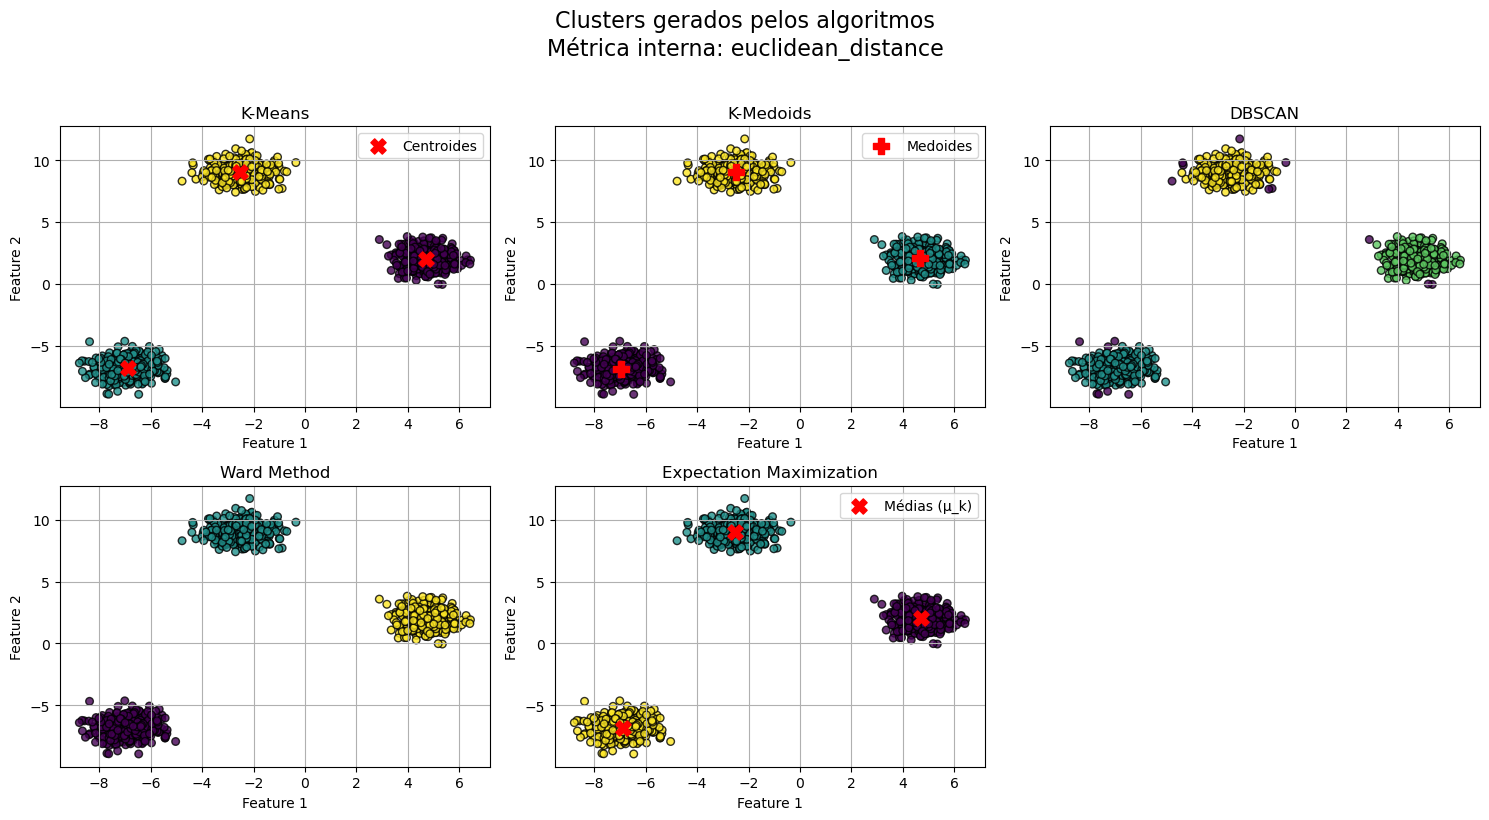

In [25]:
labels_dict = {
    "K-Means": clusters_kmeans,
    "K-Medoids": clusters_kmedoids,
    "DBSCAN": labels_dbscan,
    "Ward Method": labels_ward,
    "Expectation Maximization": labels_em,
}

models_dict = {
    "K-Means": kmeans,
    "K-Medoids": kmedoids,
    "DBSCAN": dbscan,
    "Ward Method": ward,
    "Expectation Maximization": em,
}

plot_all_clusters_with_centers(X, labels_dict, models_dict, metric_name=metric_name)


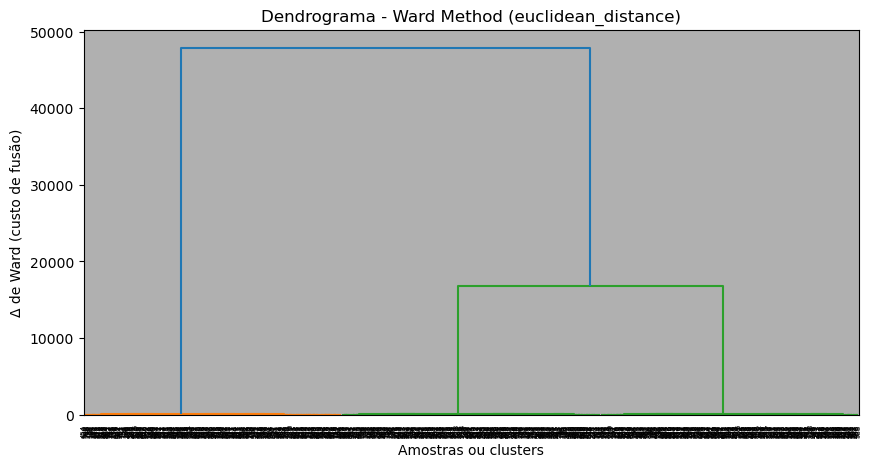

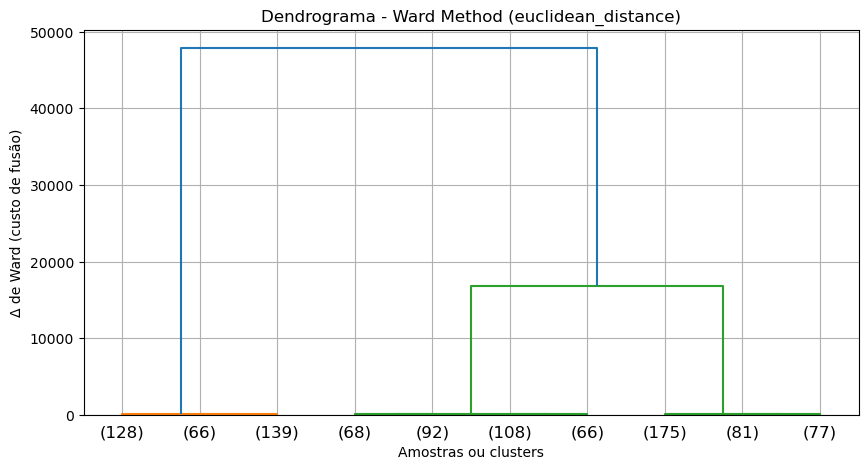

In [14]:
# Plotar dendrograma completo
ward.plot_dendrogram()

# Plotar dendrograma truncado (últimos merges)
ward.plot_dendrogram(truncate_mode='lastp', p=10)

### Métrica interna: Distância Manhattan

In [26]:
metric_name = 'manhattan_distance'
results_manhattan = []

In [35]:
# instaciando o KMeans
kmeans = KMeans(k=3, max_iterations=7000, metric_name=metric_name)
t0 = time()
centroids_kmeans, clusters_kmeans = kmeans.fit(X)
runtime_kmeans = time() - t0
results_manhattan.append(calculate_clustering_metrics(algorithm_name="K-Means", metric_name=metric_name, runtime=runtime_kmeans, X=X, labels=clusters_kmeans))

Convergiu na iteração 2


In [29]:
#instanciando o KMedoids
kmedoids = KMedoids(k=3, max_iterations=7000, metric_name=metric_name)
t0 = time()
centroids_kmedoids, clusters_kmedoids = kmedoids.fit(X)
runtime_kmedoids = time() - t0
results_manhattan.append(calculate_clustering_metrics(algorithm_name="K-Medoids", metric_name=metric_name, runtime=runtime_kmedoids, X=X, labels=clusters_kmedoids))

K-Medoids convergiu na iteração 3


In [31]:
#instanciando o DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5, metric=metric_name)
t0 = time()
dbscan.fit(X)
runtime_dbscan = time() - t0
labels_dbscan = dbscan.labels_
results_manhattan.append(calculate_clustering_metrics(algorithm_name="DBSCAN", metric_name=metric_name, runtime=runtime_dbscan, X=X, labels=labels_dbscan))

In [32]:
#instanciando o WardMethod
ward = WardMethod(k=3, metric=metric_name)
t0 = time()
labels_ward = ward.fit_predict(X)
runtime_ward = time() - t0
results_manhattan.append(calculate_clustering_metrics(algorithm_name="Ward Method", metric_name=metric_name, runtime=runtime_ward, X=X, labels=labels_ward))

/root/jane-oliveira/tcc-git/clustering-client-segmentation-tcc/src/wardmethod.py:66: UserWarning: WardMethod: o método de Ward clássico é definido para distância Euclidiana. Outras métricas são experimentais e não preservam a interpretação exata de variância mínima.
  warnings.warn(


In [33]:
#instanciando o ExpectationMaximization
em = ExpectationMaximization(n_clusters=3, max_iterations=7000, metric_name=metric_name)
t0 = time()
em.fit(X)
runtime_em = time() - t0
labels_em = em.labels_ 
results_manhattan.append(calculate_clustering_metrics(algorithm_name="Expectation Maximization", metric_name=metric_name, runtime=runtime_em, X=X, labels=labels_em))

/root/jane-oliveira/tcc-git/clustering-client-segmentation-tcc/src/expectationmaximization.py:69: UserWarning: ExpectationMaximization: com métricas diferentes de 'mahalanobis_distance', o algoritmo deixa de ser um GMM probabilisticamente consistente e passa a ser uma variante experimental de soft-clustering baseada em distância.
  warnings.warn(


In [38]:
#results_manhattan.pop()
df_results_manhattan = pd.DataFrame(results_manhattan)
df_results_manhattan

,algorithm,internal_metric,n_clusters_found,runtime_sec,sse_euclidean,silhouette,davies_bouldin,calinski_harabasz
0,K-Medoids,manhattan_distance,3,3.999019,955.931935,0.890534,0.153946,33730.393532
1,DBSCAN,manhattan_distance,3,7.536963,832.737841,0.832942,1.156826,7309.781073
2,Ward Method,manhattan_distance,3,747.909561,955.931935,0.890534,0.153946,33730.393532
3,Expectation Maximization,manhattan_distance,3,0.017849,955.931935,0.890534,0.153946,33730.393532
4,K-Means,manhattan_distance,3,0.030026,955.931935,0.890534,0.153946,33730.393532


##### Plot - Resultados para distância Manhattan

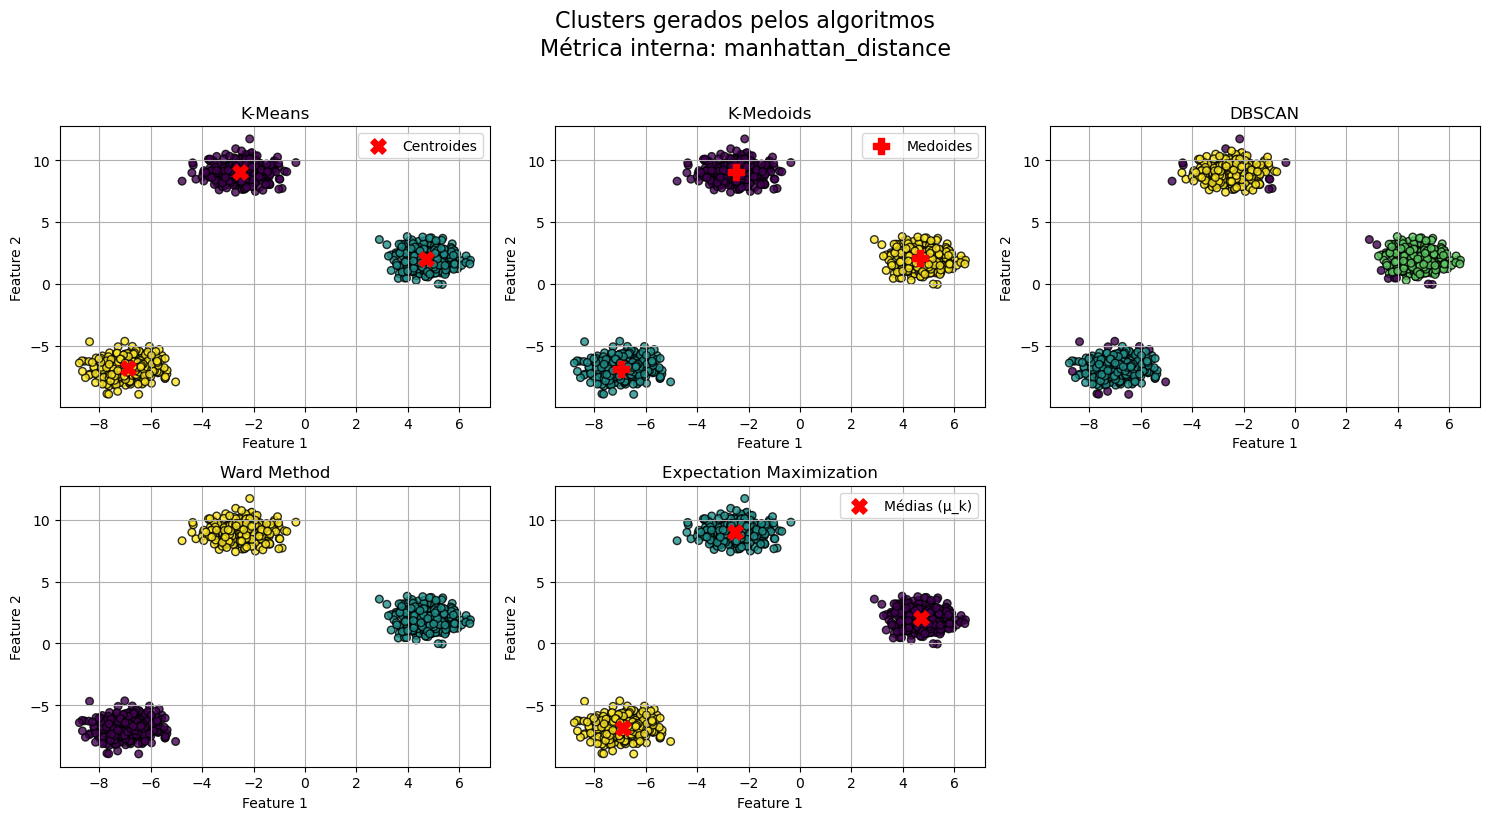

In [39]:
labels_dict = {
    "K-Means": clusters_kmeans,
    "K-Medoids": clusters_kmedoids,
    "DBSCAN": labels_dbscan,
    "Ward Method": labels_ward,
    "Expectation Maximization": labels_em,
}

models_dict = {
    "K-Means": kmeans,
    "K-Medoids": kmedoids,
    "DBSCAN": dbscan,
    "Ward Method": ward,
    "Expectation Maximization": em,
}

plot_all_clusters_with_centers(X, labels_dict, models_dict, metric_name=metric_name)

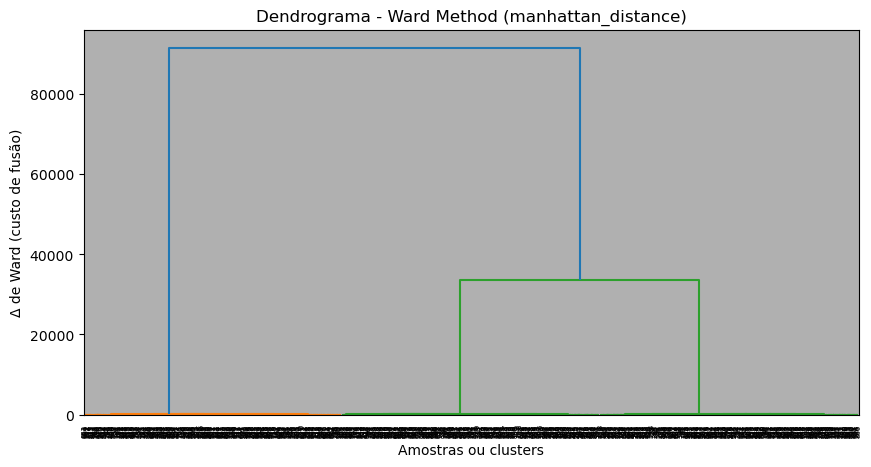

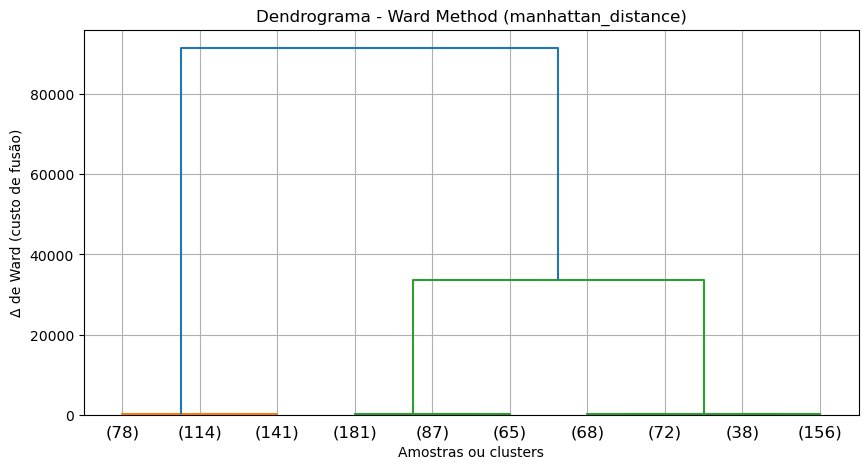

In [40]:
# Plotar dendrograma completo
ward.plot_dendrogram()

# Plotar dendrograma truncado (últimos merges)
ward.plot_dendrogram(truncate_mode='lastp', p=10)

### Métrica interna: Distância Cosine

In [41]:
metric_name = 'cosine_distance'
results_cosine = []

In [42]:
# instaciando o KMeans
kmeans = KMeans(k=3, max_iterations=7000, metric_name=metric_name)
t0 = time()
centroids_kmeans, clusters_kmeans = kmeans.fit(X)
runtime_kmeans = time() - t0
results_cosine.append(calculate_clustering_metrics(algorithm_name="K-Means", metric_name=metric_name, runtime=runtime_kmeans, X=X, labels=clusters_kmeans))

Convergiu na iteração 3


In [43]:
#instanciando o KMedoids
kmedoids = KMedoids(k=3, max_iterations=7000, metric_name=metric_name)
t0 = time()
centroids_kmedoids, clusters_kmedoids = kmedoids.fit(X)
runtime_kmedoids = time() - t0
results_cosine.append(calculate_clustering_metrics(algorithm_name="K-Medoids", metric_name=metric_name, runtime=runtime_kmedoids, X=X, labels=clusters_kmedoids))

K-Medoids convergiu na iteração 3


In [51]:
#instanciando o DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5, metric=metric_name)
t0 = time()
dbscan.fit(X)
runtime_dbscan = time() - t0
labels_dbscan = dbscan.labels_
results_cosine.append(calculate_clustering_metrics(algorithm_name="DBSCAN", metric_name=metric_name, runtime=runtime_dbscan, X=X, labels=labels_dbscan))

In [45]:
#instanciando o WardMethod
ward = WardMethod(k=3, metric=metric_name)
t0 = time()
labels_ward = ward.fit_predict(X)
runtime_ward = time() - t0
results_cosine.append(calculate_clustering_metrics(algorithm_name="Ward Method", metric_name=metric_name, runtime=runtime_ward, X=X, labels=labels_ward))

/root/jane-oliveira/tcc-git/clustering-client-segmentation-tcc/src/wardmethod.py:66: UserWarning: WardMethod: o método de Ward clássico é definido para distância Euclidiana. Outras métricas são experimentais e não preservam a interpretação exata de variância mínima.
  warnings.warn(


In [48]:
#instanciando o ExpectationMaximization
em = ExpectationMaximization(n_clusters=3, max_iterations=7000, metric_name=metric_name)
t0 = time()
em.fit(X)
runtime_em = time() - t0
labels_em = em.labels_ 
results_cosine.append(calculate_clustering_metrics(algorithm_name="Expectation Maximization", metric_name=metric_name, runtime=runtime_em, X=X, labels=labels_em))

/root/jane-oliveira/tcc-git/clustering-client-segmentation-tcc/src/expectationmaximization.py:69: UserWarning: ExpectationMaximization: com métricas diferentes de 'mahalanobis_distance', o algoritmo deixa de ser um GMM probabilisticamente consistente e passa a ser uma variante experimental de soft-clustering baseada em distância.
  warnings.warn(


In [54]:
#results_cosine.pop()
df_results_cosine = pd.DataFrame(results_cosine)
df_results_cosine

,algorithm,internal_metric,n_clusters_found,runtime_sec,sse_euclidean,silhouette,davies_bouldin,calinski_harabasz
0,K-Means,cosine_distance,3,0.063115,955.931935,0.890534,0.153946,33730.393532
1,K-Medoids,cosine_distance,3,6.143375,955.931935,0.890534,0.153946,33730.393532
2,DBSCAN,cosine_distance,2,11.171934,17767.586480,0.728966,0.404458,2688.861061
3,Ward Method,cosine_distance,3,1068.773485,955.931935,0.890534,0.153946,33730.393532
4,Expectation Maximization,cosine_distance,1,4.532469,65637.898532,NaN,NaN,NaN


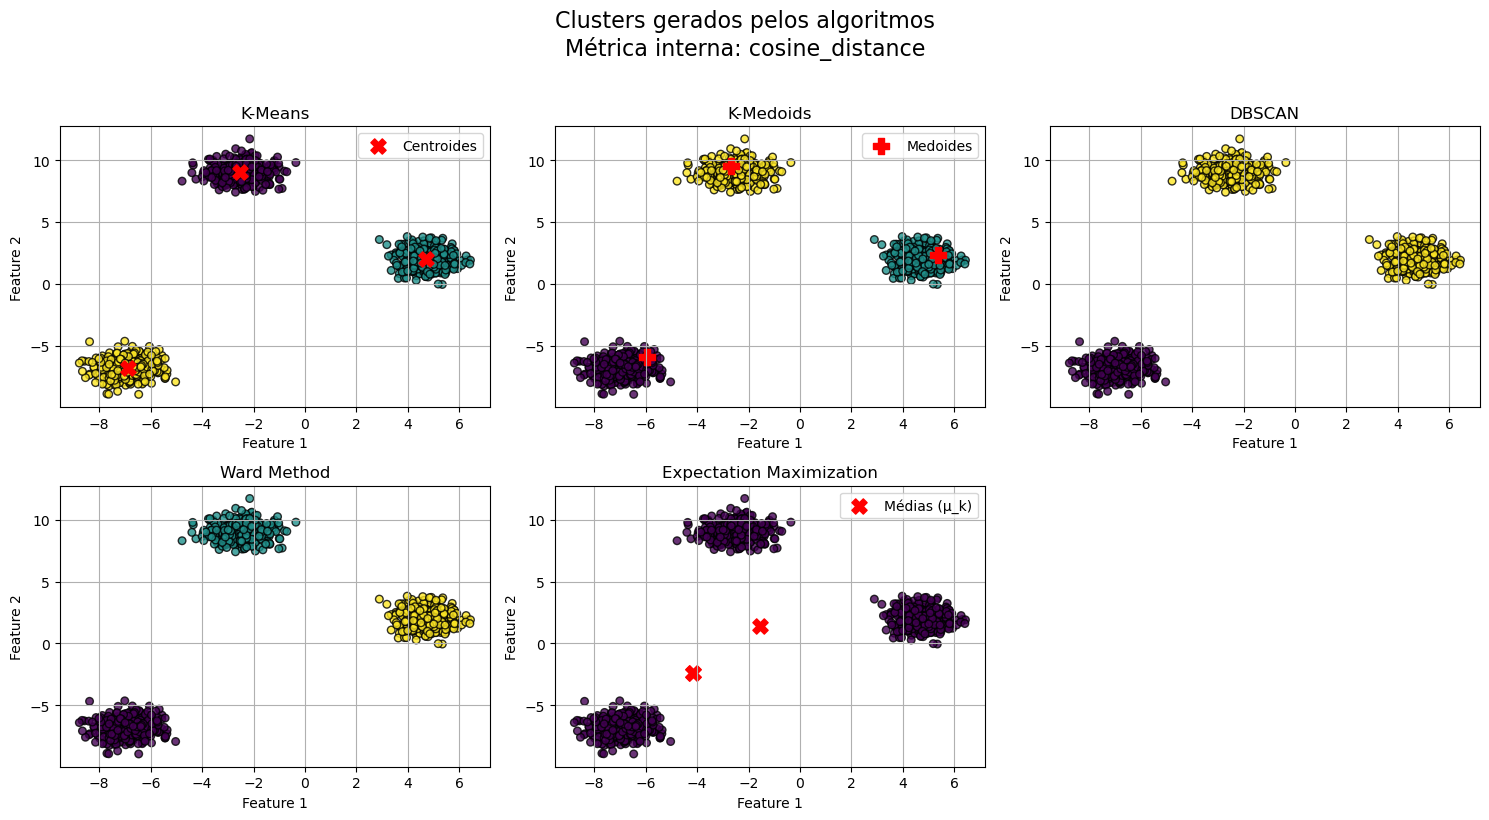

In [55]:
labels_dict = {
    "K-Means": clusters_kmeans,
    "K-Medoids": clusters_kmedoids,
    "DBSCAN": labels_dbscan,
    "Ward Method": labels_ward,
    "Expectation Maximization": labels_em,
}

models_dict = {
    "K-Means": kmeans,
    "K-Medoids": kmedoids,
    "DBSCAN": dbscan,
    "Ward Method": ward,
    "Expectation Maximization": em,
}

plot_all_clusters_with_centers(X, labels_dict, models_dict, metric_name=metric_name)

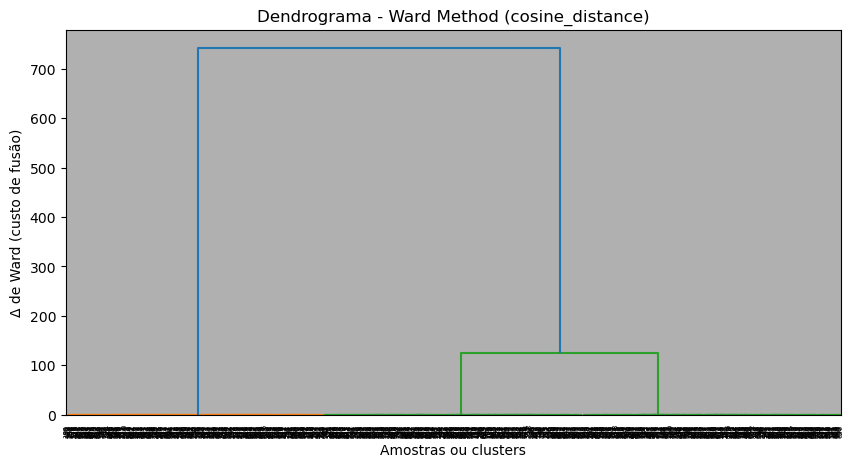

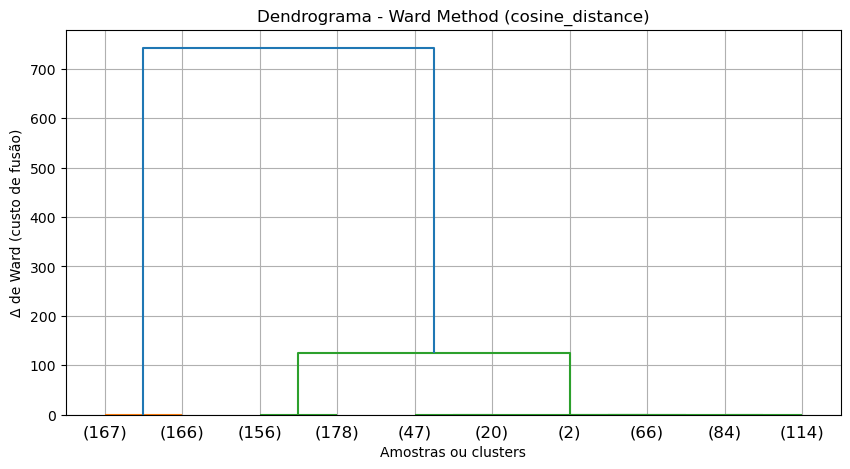

In [56]:
# Plotar dendrograma completo
ward.plot_dendrogram()

# Plotar dendrograma truncado (últimos merges)
ward.plot_dendrogram(truncate_mode='lastp', p=10)

### Métrica interna: Distância Mahalanobis

In [7]:
metric_name = 'mahalanobis_distance'
results_mahalanobis = []

In [8]:
# instaciando o KMeans
kmeans = KMeans(k=3, max_iterations=7000, metric_name=metric_name)
t0 = time()
centroids_kmeans, clusters_kmeans = kmeans.fit(X)
runtime_kmeans = time() - t0
results_mahalanobis.append(calculate_clustering_metrics(algorithm_name="K-Means", metric_name=metric_name, runtime=runtime_kmeans, X=X, labels=clusters_kmeans))

Convergiu na iteração 3


In [9]:
#instanciando o KMedoids
kmedoids = KMedoids(k=3, max_iterations=7000, metric_name=metric_name)
t0 = time()
centroids_kmedoids, clusters_kmedoids = kmedoids.fit(X)
runtime_kmedoids = time() - t0
results_mahalanobis.append(calculate_clustering_metrics(algorithm_name="K-Medoids", metric_name=metric_name, runtime=runtime_kmedoids, X=X, labels=clusters_kmedoids))

K-Medoids convergiu na iteração 4


In [10]:
#instanciando o DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5, metric=metric_name)
t0 = time()
dbscan.fit(X)
runtime_dbscan = time() - t0
labels_dbscan = dbscan.labels_
results_mahalanobis.append(calculate_clustering_metrics(algorithm_name="DBSCAN", metric_name=metric_name, runtime=runtime_dbscan, X=X, labels=labels_dbscan))

In [13]:
#instanciando o WardMethod
ward = WardMethod(k=3, metric=metric_name)
t0 = time()
labels_ward = ward.fit_predict(X)
runtime_ward = time() - t0
results_mahalanobis.append(calculate_clustering_metrics(algorithm_name="Ward Method", metric_name=metric_name, runtime=runtime_ward, X=X, labels=labels_ward))

/root/jane-oliveira/tcc-git/clustering-client-segmentation-tcc/src/wardmethod.py:42: UserWarning: WardMethod: o método de Ward clássico é definido para distância Euclidiana. Outras métricas são experimentais e não preservam a interpretação exata de variância mínima.
  warnings.warn(


In [11]:
#instanciando o ExpectationMaximization
em = ExpectationMaximization(n_clusters=3, max_iterations=7000, metric_name=metric_name)
t0 = time()
em.fit(X)
runtime_em = time() - t0
labels_em = em.labels_ 
results_mahalanobis.append(calculate_clustering_metrics(algorithm_name="Expectation Maximization", metric_name=metric_name, runtime=runtime_em, X=X, labels=labels_em))

In [14]:
#results_mahalanobis.pop()
df_results_mahalanobis = pd.DataFrame(results_mahalanobis)
df_results_mahalanobis

,algorithm,internal_metric,n_clusters_found,runtime_sec,sse_euclidean,silhouette,davies_bouldin,calinski_harabasz
0,K-Means,mahalanobis_distance,3,0.058697,955.931935,0.890534,0.153946,33730.393532
1,K-Medoids,mahalanobis_distance,3,6.703836,955.931935,0.890534,0.153946,33730.393532
2,DBSCAN,mahalanobis_distance,3,9.053781,955.931935,0.890534,0.153946,33730.393532
3,Expectation Maximization,mahalanobis_distance,3,0.028720,955.931935,0.890534,0.153946,33730.393532
4,Ward Method,mahalanobis_distance,3,897.355001,955.931935,0.890534,0.153946,33730.393532


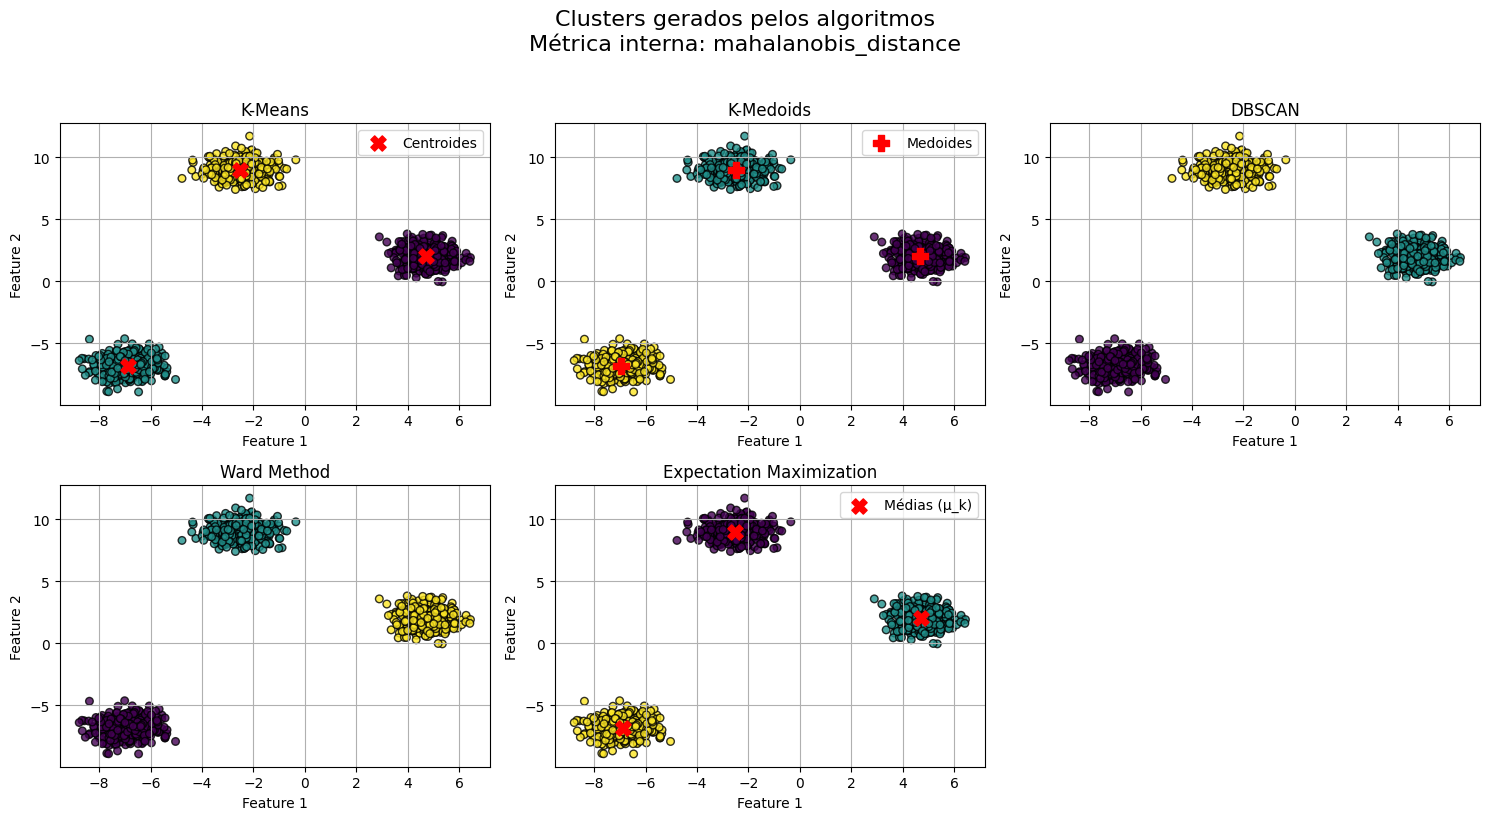

In [15]:
labels_dict = {
    "K-Means": clusters_kmeans,
    "K-Medoids": clusters_kmedoids,
    "DBSCAN": labels_dbscan,
    "Ward Method": labels_ward,
    "Expectation Maximization": labels_em,
}

models_dict = {
    "K-Means": kmeans,
    "K-Medoids": kmedoids,
    "DBSCAN": dbscan,
    "Ward Method": ward,
    "Expectation Maximization": em,
}

plot_all_clusters_with_centers(X, labels_dict, models_dict, metric_name=metric_name)

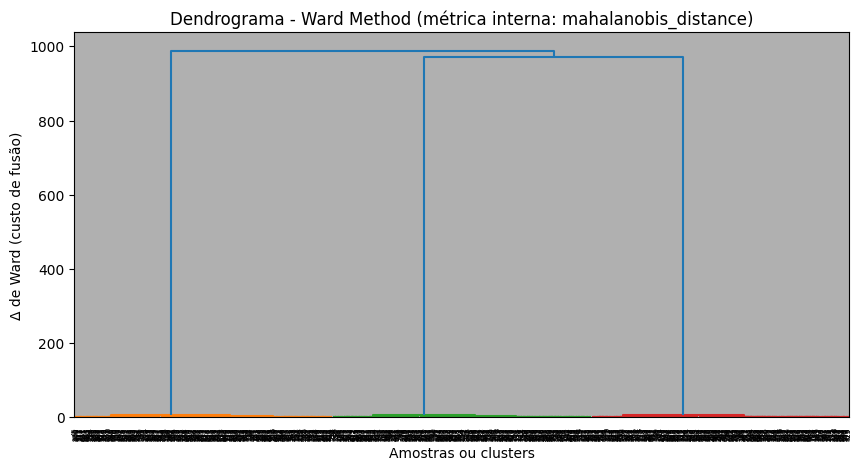

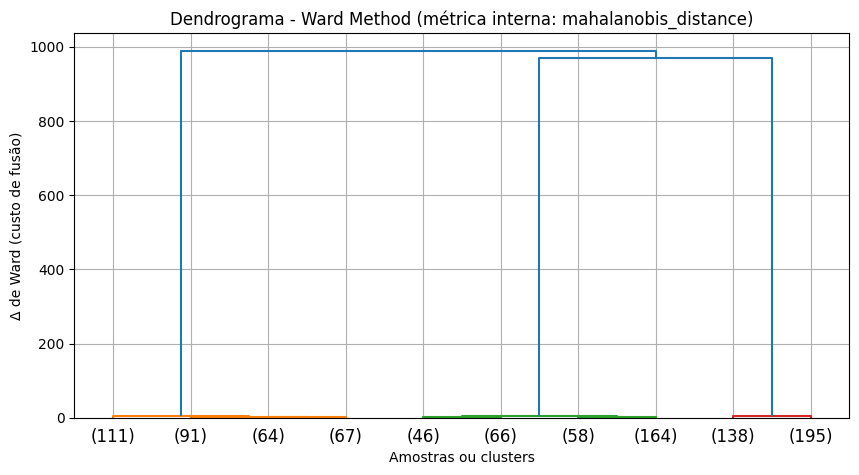

In [16]:
# Plotar dendrograma completo
ward.plot_dendrogram()

# Plotar dendrograma truncado (últimos merges)
ward.plot_dendrogram(truncate_mode='lastp', p=10)


### Métrica interna: Distância Jensen-Shannon

In [17]:
metric_name = 'jensen-shannon_distance'
results_jensen_shannon = []

In [18]:
# instaciando o KMeans
kmeans = KMeans(k=3, max_iterations=7000, metric_name=metric_name)
t0 = time()
centroids_kmeans, clusters_kmeans = kmeans.fit(X)
runtime_kmeans = time() - t0
results_jensen_shannon.append(calculate_clustering_metrics(algorithm_name="K-Means", metric_name=metric_name, runtime=runtime_kmeans, X=X, labels=clusters_kmeans))

Convergiu na iteração 5


In [19]:
#instanciando o KMedoids
kmedoids = KMedoids(k=3, max_iterations=7000, metric_name=metric_name)
t0 = time()
centroids_kmedoids, clusters_kmedoids = kmedoids.fit(X)
runtime_kmedoids = time() - t0
results_jensen_shannon.append(calculate_clustering_metrics(algorithm_name="K-Medoids", metric_name=metric_name, runtime=runtime_kmedoids, X=X, labels=clusters_kmedoids))

K-Medoids convergiu na iteração 6


In [20]:
#instanciando o DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5, metric=metric_name)
t0 = time()
dbscan.fit(X)
runtime_dbscan = time() - t0
labels_dbscan = dbscan.labels_
results_jensen_shannon.append(calculate_clustering_metrics(algorithm_name="DBSCAN", metric_name=metric_name, runtime=runtime_dbscan, X=X, labels=labels_dbscan))

In [22]:
#instanciando o WardMethod
ward = WardMethod(k=3, metric=metric_name)
t0 = time()
labels_ward = ward.fit_predict(X)
runtime_ward = time() - t0
results_jensen_shannon.append(calculate_clustering_metrics(algorithm_name="Ward Method", metric_name=metric_name, runtime=runtime_ward, X=X, labels=labels_ward))

/root/jane-oliveira/tcc-git/clustering-client-segmentation-tcc/src/wardmethod.py:42: UserWarning: WardMethod: o método de Ward clássico é definido para distância Euclidiana. Outras métricas são experimentais e não preservam a interpretação exata de variância mínima.
  warnings.warn(


In [21]:
#instanciando o ExpectationMaximization
em = ExpectationMaximization(n_clusters=3, max_iterations=7000, metric_name=metric_name)
t0 = time()
em.fit(X)
runtime_em = time() - t0
labels_em = em.labels_ 
results_jensen_shannon.append(calculate_clustering_metrics(algorithm_name="Expectation Maximization", metric_name=metric_name, runtime=runtime_em, X=X, labels=labels_em))

/root/jane-oliveira/tcc-git/clustering-client-segmentation-tcc/src/expectationmaximization.py:69: UserWarning: ExpectationMaximization: com métricas diferentes de 'mahalanobis_distance', o algoritmo deixa de ser um GMM probabilisticamente consistente e passa a ser uma variante experimental de soft-clustering baseada em distância.
  warnings.warn(


In [23]:
#results_jensen_shannon.pop()
df_results_jensen_shannon = pd.DataFrame(results_jensen_shannon)
df_results_jensen_shannon

,algorithm,internal_metric,n_clusters_found,runtime_sec,sse_euclidean,silhouette,davies_bouldin,calinski_harabasz
0,K-Means,jensen-shannon_distance,3,0.680331,11129.355535,0.757654,0.338068,2441.516816
1,K-Medoids,jensen-shannon_distance,3,88.255401,10807.285889,0.762490,0.329476,2529.132724
2,DBSCAN,jensen-shannon_distance,1,86.944059,65637.898532,NaN,NaN,NaN
3,Expectation Maximization,jensen-shannon_distance,1,0.777659,65637.898532,NaN,NaN,NaN
4,Ward Method,jensen-shannon_distance,3,7428.415114,6227.009166,0.824133,0.210284,4756.108038


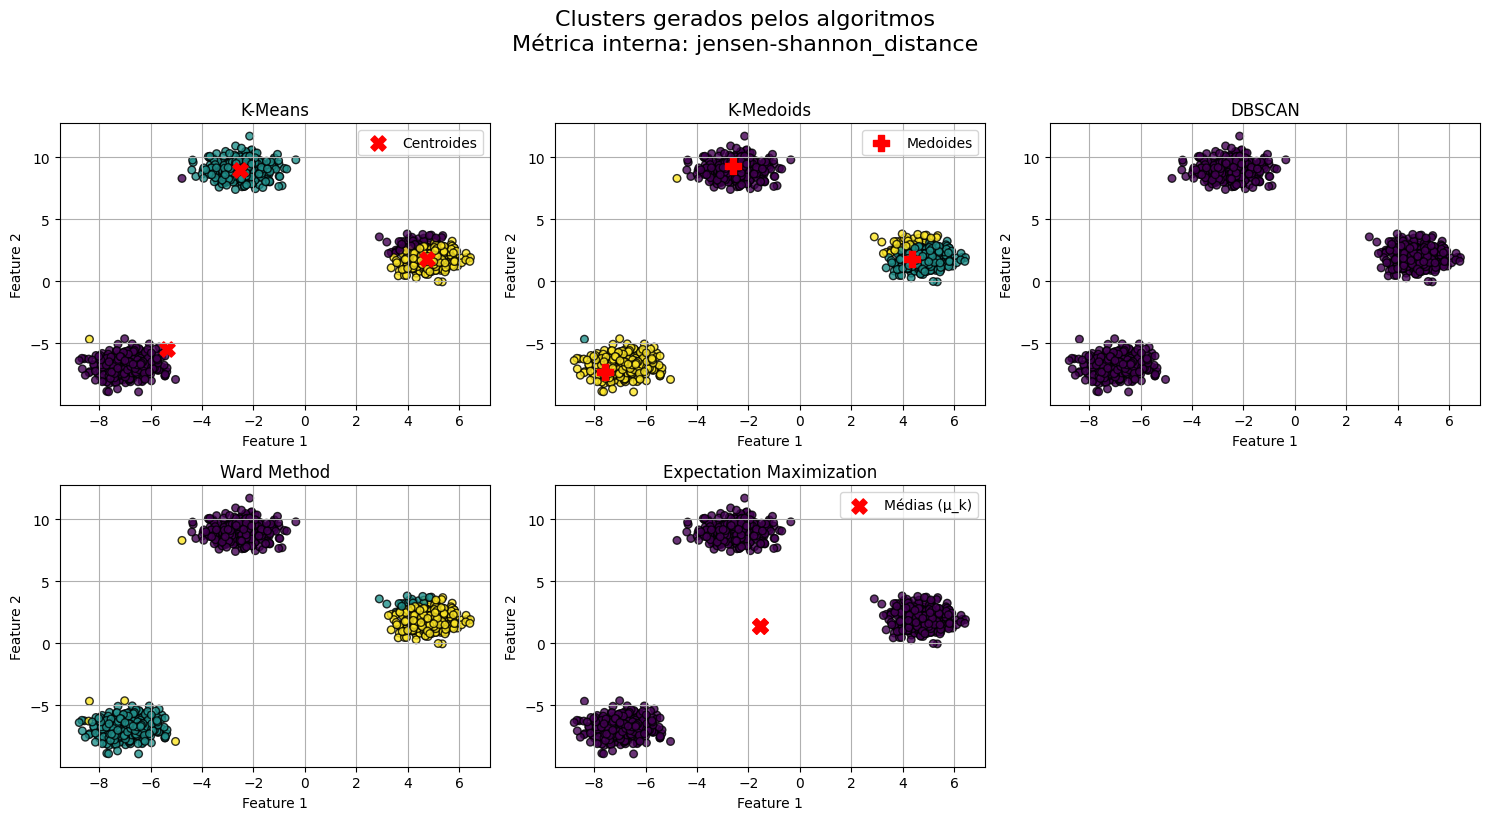

In [24]:
labels_dict = {
    "K-Means": clusters_kmeans,
    "K-Medoids": clusters_kmedoids,
    "DBSCAN": labels_dbscan,
    "Ward Method": labels_ward,
    "Expectation Maximization": labels_em,
}

models_dict = {
    "K-Means": kmeans,
    "K-Medoids": kmedoids,
    "DBSCAN": dbscan,
    "Ward Method": ward,
    "Expectation Maximization": em,
}

plot_all_clusters_with_centers(X, labels_dict, models_dict, metric_name=metric_name)

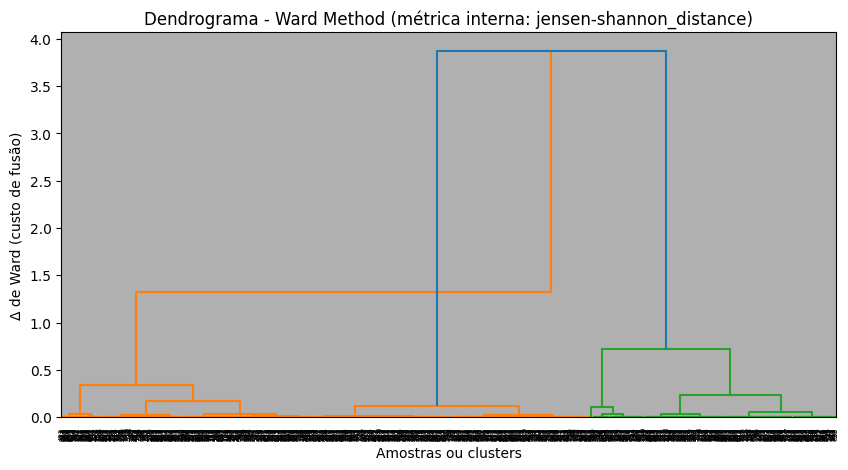

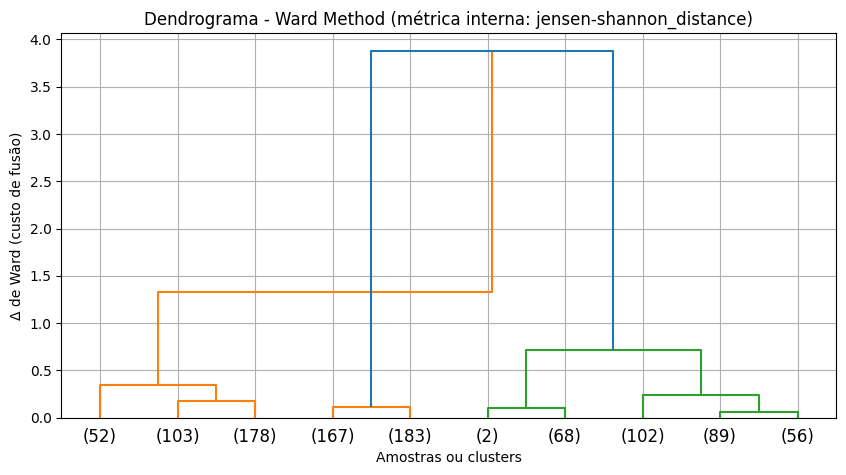

In [25]:
# Plotar dendrograma completo
ward.plot_dendrogram()

# Plotar dendrograma truncado (últimos merges)
ward.plot_dendrogram(truncate_mode='lastp', p=10)

In [85]:
def generate_categorical_distributions(n_samples=1000, n_clusters=4, dim=4, spread=0.03, random_state=42):
    """
    Gera clusters onde cada ponto é uma distribuição categórica
    (ideal para Jensen–Shannon Distance).
    """

    rng = np.random.default_rng(random_state)

    # Centróides aleatórios no simplex
    centroids = rng.random((n_clusters, dim))
    centroids = centroids / centroids.sum(axis=1, keepdims=True)

    X = []
    y = []

    for k in range(n_clusters):
        for _ in range(n_samples // n_clusters):
            # Adiciona ruído pequeno, mantendo distribuição válida
            vec = centroids[k] + spread * rng.normal(size=dim)
            vec = np.abs(vec)
            vec = vec / vec.sum()
            X.append(vec)
            y.append(k)

    return np.array(X), np.array(y)


In [177]:
X, labels = generate_categorical_distributions(n_samples=1000, n_clusters=3, dim=2, spread=0.01, random_state=42)


results_jensen_shannon_v2 = []

In [178]:
# instaciando o KMeans
kmeans = KMeans(k=3, max_iterations=7000, metric_name=metric_name)
t0 = time()
centroids_kmeans, clusters_kmeans = kmeans.fit(X)
runtime_kmeans = time() - t0
results_jensen_shannon_v2.append(calculate_clustering_metrics(algorithm_name="K-Means", metric_name=metric_name, runtime=runtime_kmeans, X=X, labels=clusters_kmeans))

Convergiu na iteração 4


In [180]:
#instanciando o KMedoids
kmedoids = KMedoids(k=3, max_iterations=7000, metric_name=metric_name)
t0 = time()
centroids_kmedoids, clusters_kmedoids = kmedoids.fit(X)
runtime_kmedoids = time() - t0
results_jensen_shannon_v2.append(calculate_clustering_metrics(algorithm_name="K-Medoids", metric_name=metric_name, runtime=runtime_kmedoids, X=X, labels=clusters_kmedoids))

K-Medoids convergiu na iteração 3


In [181]:
#instanciando o DBSCAN
dbscan = DBSCAN(eps=0.01, min_samples=5, metric=metric_name)
t0 = time()
dbscan.fit(X)
runtime_dbscan = time() - t0
labels_dbscan = dbscan.labels_
results_jensen_shannon_v2.append(calculate_clustering_metrics(algorithm_name="DBSCAN", metric_name=metric_name, runtime=runtime_dbscan, X=X, labels=labels_dbscan))

In [182]:
#instanciando o WardMethod
ward = WardMethod(k=3, metric=metric_name)
t0 = time()
labels_ward = ward.fit_predict(X)
runtime_ward = time() - t0
results_jensen_shannon_v2.append(calculate_clustering_metrics(algorithm_name="Ward Method", metric_name=metric_name, runtime=runtime_ward, X=X, labels=labels_ward))

/root/jane-oliveira/tcc-git/clustering-client-segmentation-tcc/src/wardmethod.py:42: UserWarning: WardMethod: o método de Ward clássico é definido para distância Euclidiana. Outras métricas são experimentais e não preservam a interpretação exata de variância mínima.
  warnings.warn(


In [183]:
#instanciando o ExpectationMaximization
em = ExpectationMaximization(n_clusters=3, max_iterations=7000, metric_name=metric_name)
t0 = time()
em.fit(X)
runtime_em = time() - t0
labels_em = em.labels_ 
results_jensen_shannon_v2.append(calculate_clustering_metrics(algorithm_name="Expectation Maximization", metric_name=metric_name, runtime=runtime_em, X=X, labels=labels_em))

/root/jane-oliveira/tcc-git/clustering-client-segmentation-tcc/src/expectationmaximization.py:69: UserWarning: ExpectationMaximization: com métricas diferentes de 'mahalanobis_distance', o algoritmo deixa de ser um GMM probabilisticamente consistente e passa a ser uma variante experimental de soft-clustering baseada em distância.
  warnings.warn(


In [184]:
#results_jensen_shannon_v2.pop(2)
df_results_jensen_shannonv2 = pd.DataFrame(results_jensen_shannon_v2)
df_results_jensen_shannonv2

,algorithm,internal_metric,n_clusters_found,runtime_sec,sse_euclidean,silhouette,davies_bouldin,calinski_harabasz
0,K-Means,jensen-shannon_distance,3,0.561482,0.113866,0.934717,0.089574,512649.929097
1,K-Medoids,jensen-shannon_distance,3,48.338355,0.113866,0.934717,0.089574,512649.929097
2,DBSCAN,jensen-shannon_distance,3,88.178761,0.113866,0.934717,0.089574,512649.929097
3,Ward Method,jensen-shannon_distance,3,7385.167362,0.113866,0.934717,0.089574,512649.929097
4,Expectation Maximization,jensen-shannon_distance,1,0.849201,117.329101,NaN,NaN,NaN


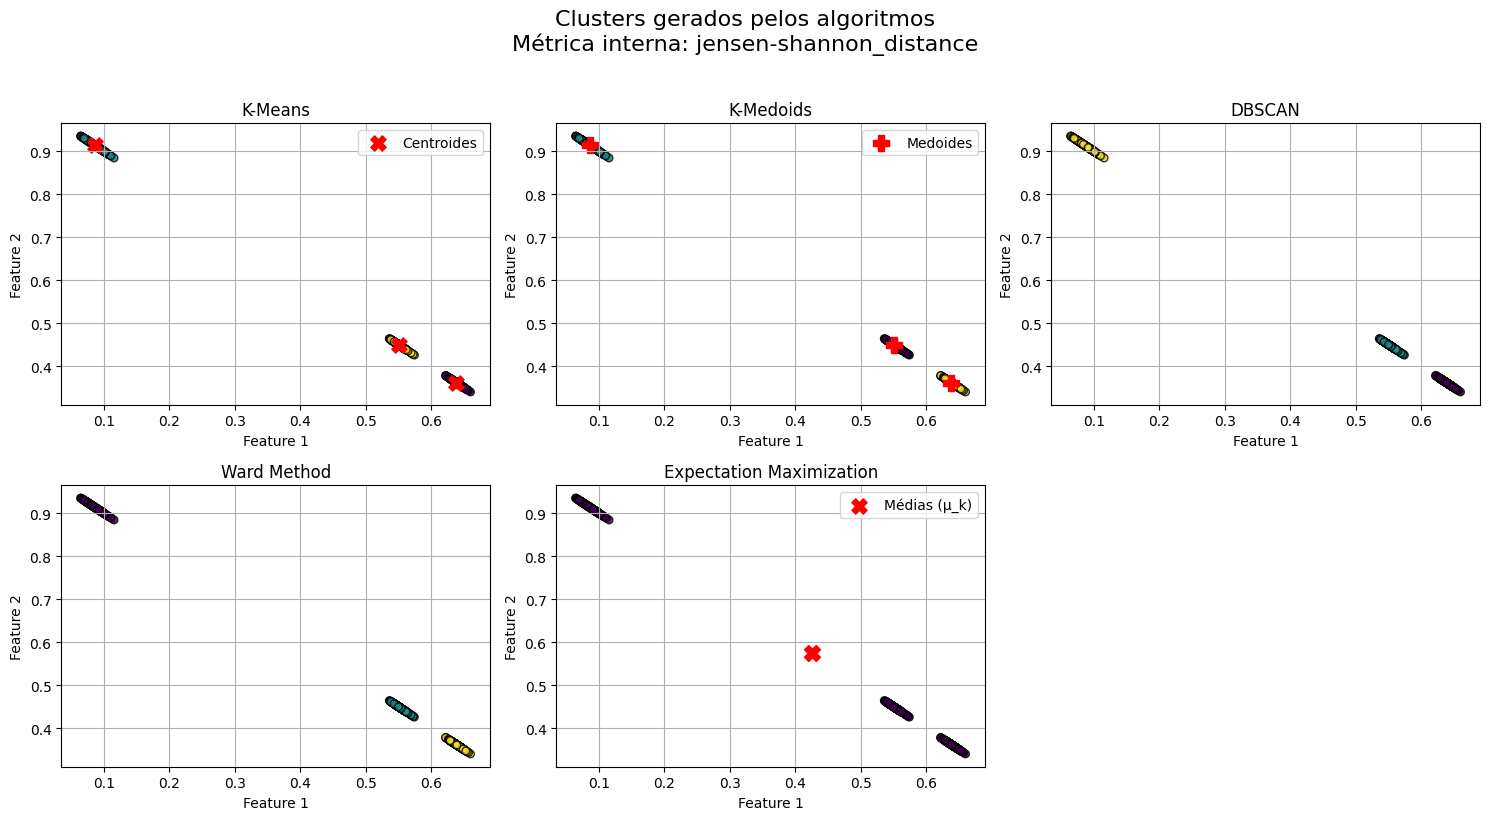

In [185]:
labels_dict = {
    "K-Means": clusters_kmeans,
    "K-Medoids": clusters_kmedoids,
    "DBSCAN": labels_dbscan,
    "Ward Method": labels_ward,
    "Expectation Maximization": labels_em,
}

models_dict = {
    "K-Means": kmeans,
    "K-Medoids": kmedoids,
    "DBSCAN": dbscan,
    "Ward Method": ward,
    "Expectation Maximization": em,
}

plot_all_clusters_with_centers(X, labels_dict, models_dict, metric_name=metric_name)

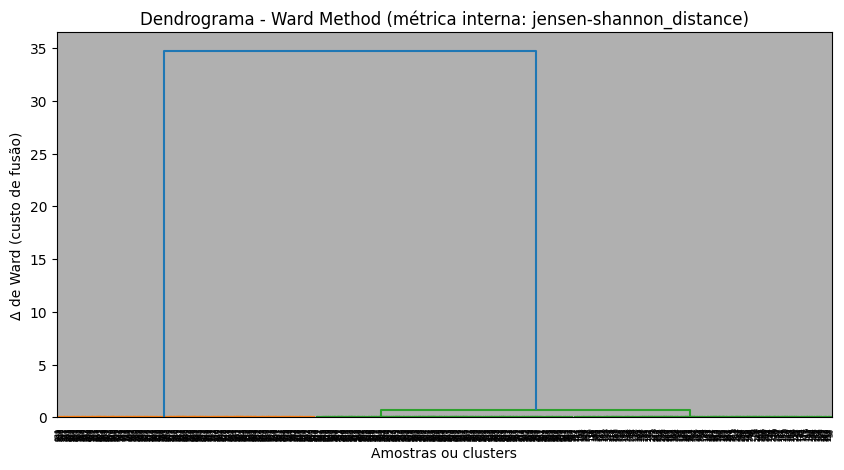

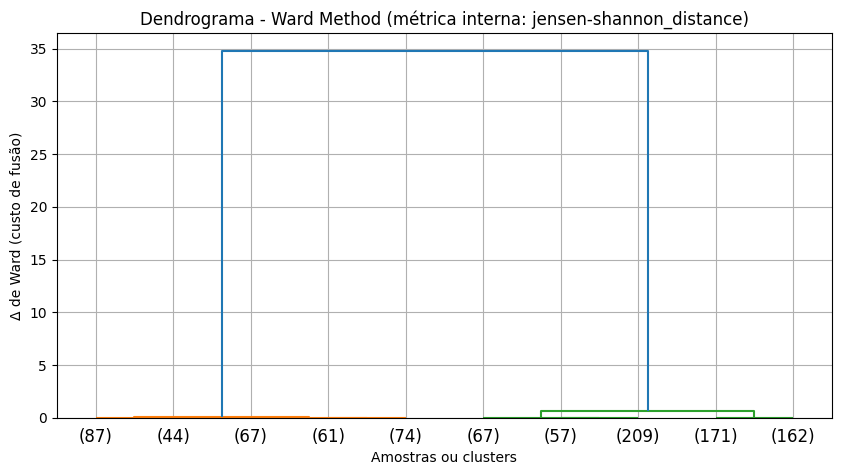

In [186]:
# Plotar dendrograma completo
ward.plot_dendrogram()

# Plotar dendrograma truncado (últimos merges)
ward.plot_dendrogram(truncate_mode='lastp', p=10)